# Screenshot Preprocessing

Exploratory edge detection and rectangle fitting on captured UI screenshots.

## Workflow
- Discover screenshots in the testing directories
- For each image, inspect the raw capture and grayscale
- Compute scene-adaptive Canny edges with auto thresholds
- Apply morphology tuned for frames vs. subtitles
- Fit rectangles and annotate likely UI regions

In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

try:
    import cv2
except ImportError as exc:
    raise ImportError(
        "OpenCV (opencv-python) is required for this notebook. Install it via `pip install opencv-python`."
    ) from exc

from IPython.display import display, Markdown

plt.rcParams["figure.figsize"] = (12, 8)
IMAGE_EXTENSIONS = {".png", ".jpg", ".jpeg", ".webp"}

def plot_image(title, image, cmap=None):
    plt.figure()
    plt.imshow(image, cmap=cmap)
    plt.title(title)
    plt.axis("off")
    plt.show()

def canny_auto(gray, sigma=1.0, hi_q=0.92, low_ratio=0.4):
    # Scene-adaptive Canny using gradient quantiles.
    if gray.ndim != 2:
        raise ValueError("Expected single-channel grayscale input.")

    blurred = cv2.GaussianBlur(gray, (0, 0), sigma)
    gx = cv2.Sobel(blurred, cv2.CV_32F, 1, 0, ksize=3)
    gy = cv2.Sobel(blurred, cv2.CV_32F, 0, 1, ksize=3)
    mag = np.sqrt(gx * gx + gy * gy)

    hi = float(np.quantile(mag, hi_q))
    if hi <= 1e-6:
        hi = 10.0
    lo = float(low_ratio * hi)
    if lo <= 0:
        lo = 0.5 * hi

    edges = cv2.Canny(blurred, lo, hi, L2gradient=True)
    return edges, (lo, hi), blurred

In [ ]:
# Directories to scan for screenshots. Adjust as needed.
DEFAULT_DIRS = [
    Path("../testing/test_images"),
]

image_paths = []
for root in DEFAULT_DIRS:
    if root.exists():
        image_paths.extend(
            path for path in root.rglob("*")
            if path.suffix.lower() in IMAGE_EXTENSIONS
        )

# Drop duplicates while preserving order
seen = set()
deduped = []
for path in image_paths:
    if path not in seen:
        deduped.append(path)
        seen.add(path)
image_paths = sorted(deduped)

print(f"Discovered {len(image_paths)} candidate screenshots.")
for sample in image_paths:
    print(f" - {sample}")
if not image_paths:
    raise FileNotFoundError(
        "No screenshots found. Update DEFAULT_DIRS or add files to the testing directories."
    )

Discovered 126 candidate screenshots.
 - ../testing/marked_snapshots/20251021_121038_074_Messages_Emma❤️.png
 - ../testing/marked_snapshots/20251021_121042_209_Cursor_window.py_—_memoir.png
 - ../testing/marked_snapshots/20251021_122151_200_Google_Chrome_Parks_&_Rec_but_all_the_Women_WANT_Ron_|_Parks_and.png
 - ../testing/marked_snapshots/20251021_122152_434_Google_Chrome_Parks_&_Rec_but_all_the_Women_WANT_Ron_|_Parks_and.png
 - ../testing/marked_snapshots/20251021_122158_689_Google_Chrome_Parks_&_Rec_but_all_the_Women_WANT_Ron_|_Parks_and.png
 - ../testing/marked_snapshots/20251021_122201_427_Google_Chrome_.png
 - ../testing/marked_snapshots/20251021_122202_303_Google_Chrome_OCR_app_screen_processing.png
 - ../testing/marked_snapshots/20251021_122207_140_Cursor_window.py_—_memoir.png
 - ../testing/marked_snapshots/20251021_122207_874_Cursor_window.py_—_memoir.png
 - ../testing/snapshots/20251020_183635_759_Google_Chrome_Window_event_monitoring_macOS.png
 - ../testing/snapshots/2025102

### 20251021_121038_074_Messages_Emma❤️.png

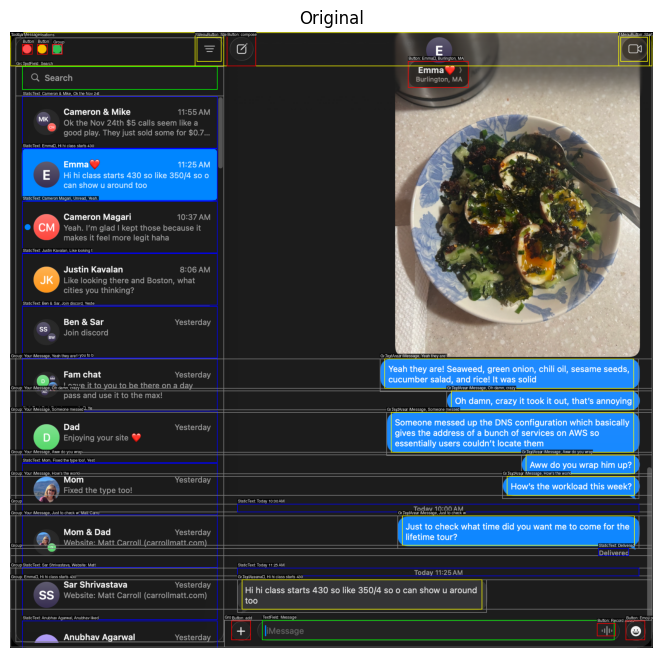

Auto Canny thresholds: low=93.60, high=208.00


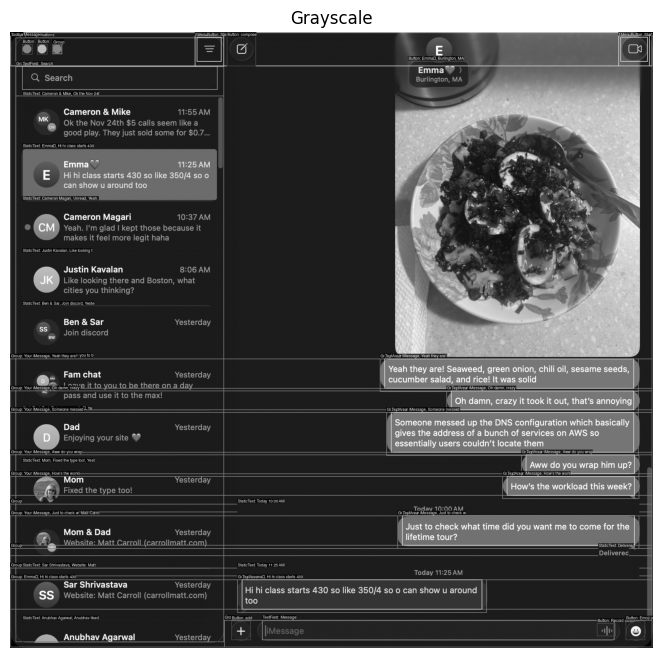

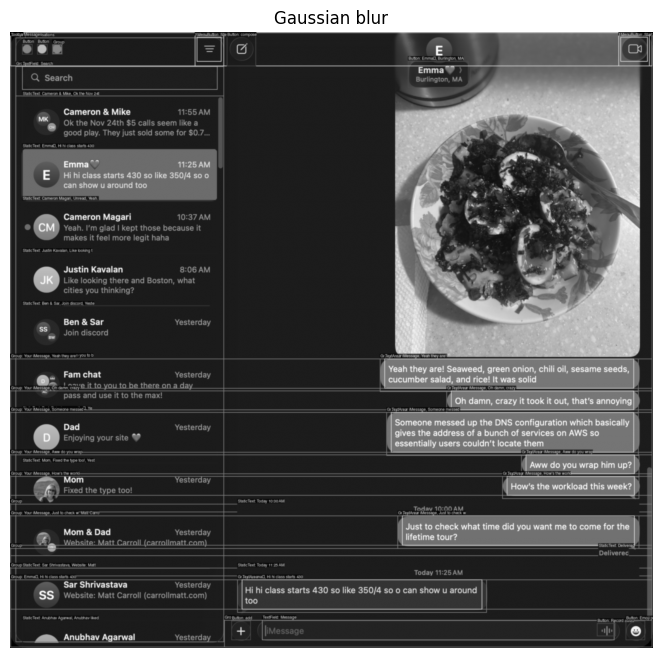

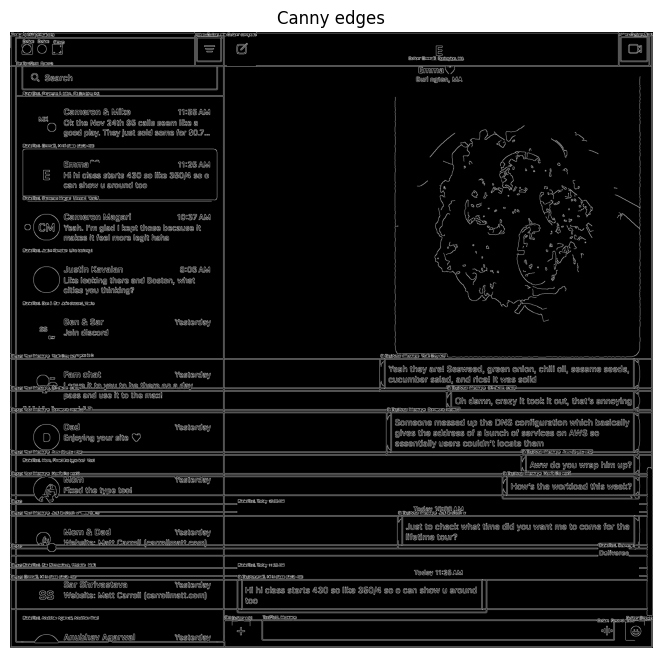

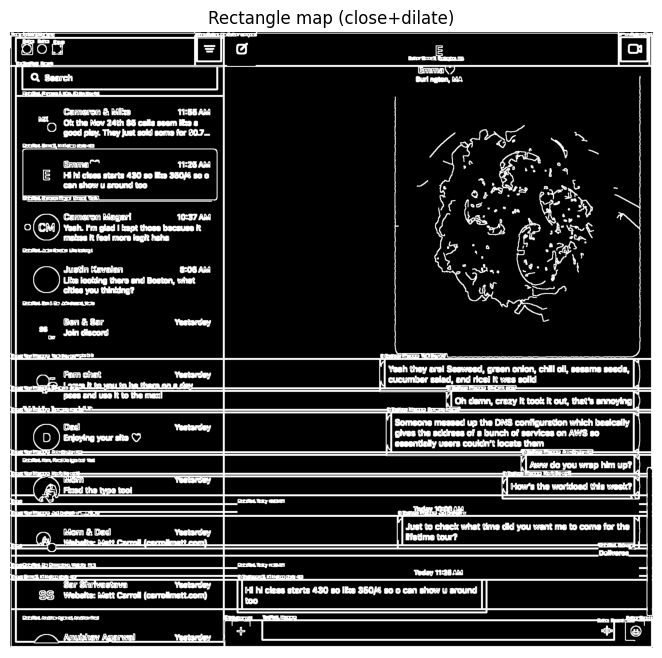

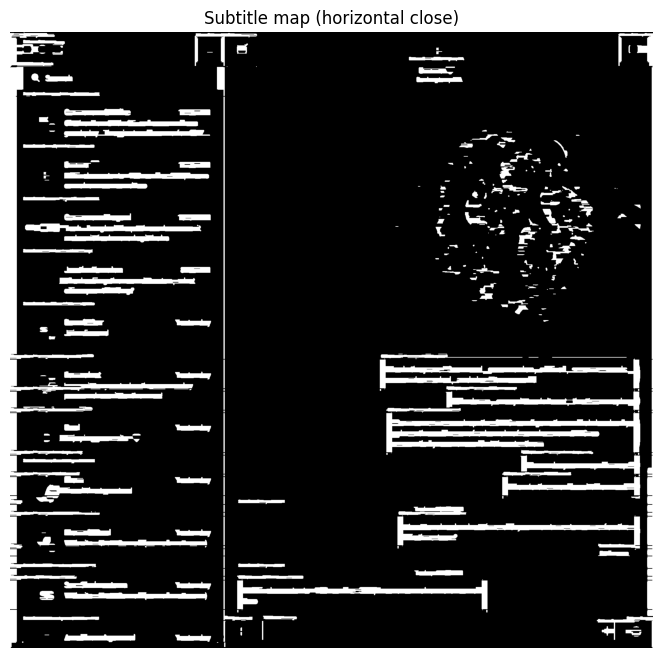

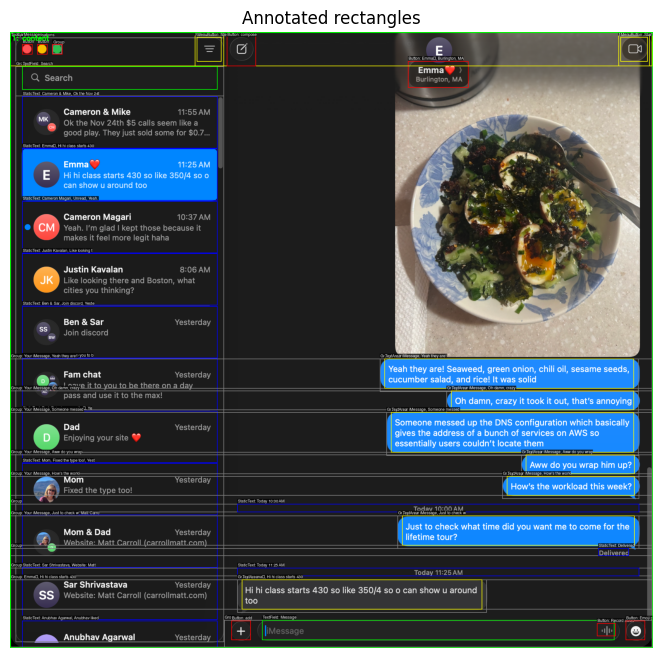

x  y     w     h  area_pct  extent  aspect_ratio    label
0  0  0  1970  1888     100.0  0.9969      1.043432  content

### 20251021_121042_209_Cursor_window.py_—_memoir.png

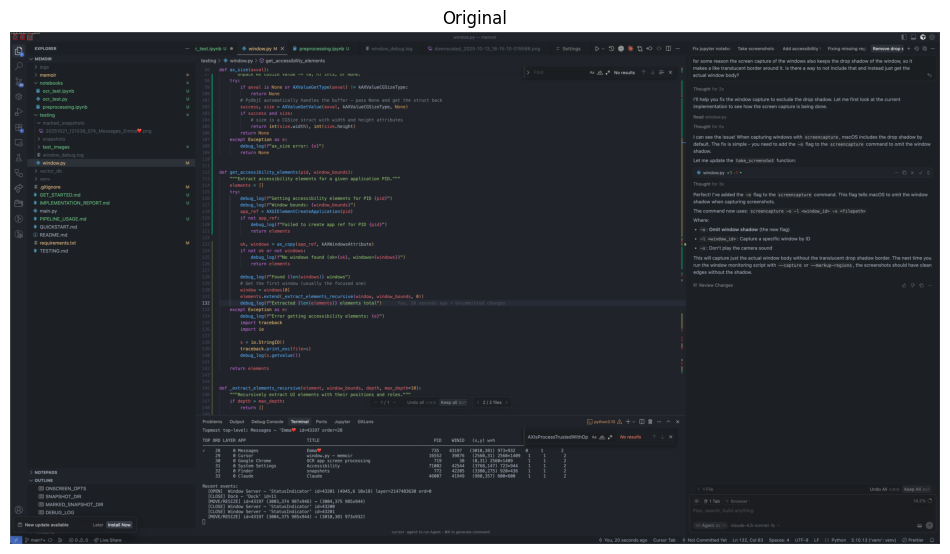

Auto Canny thresholds: low=20.25, high=45.01


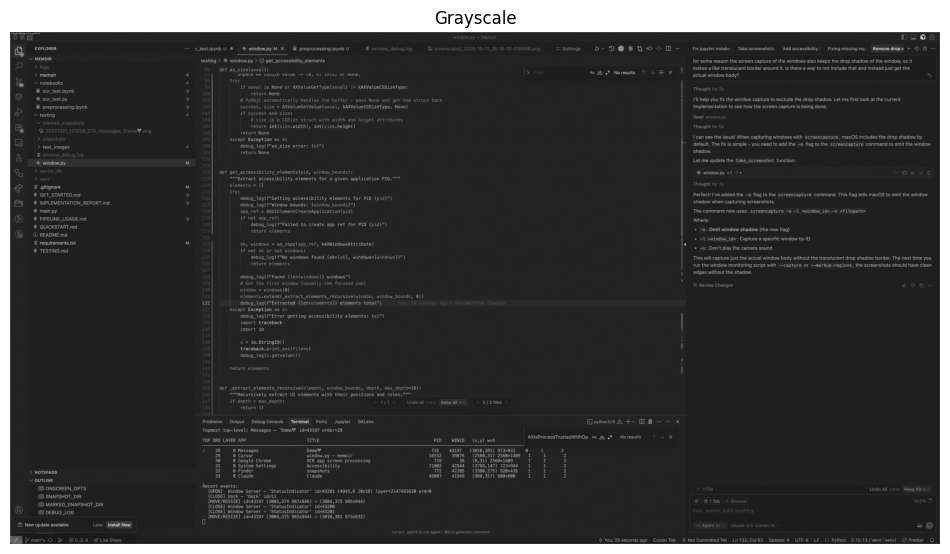

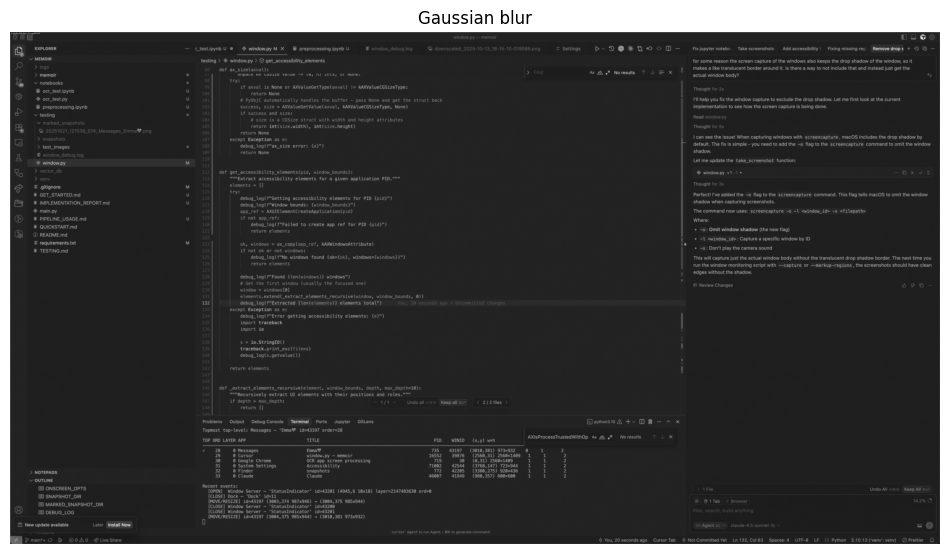

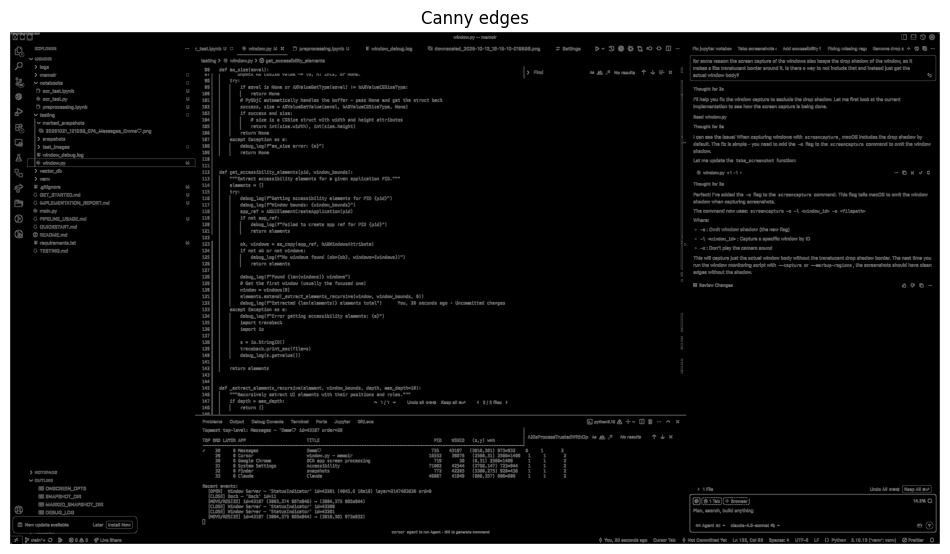

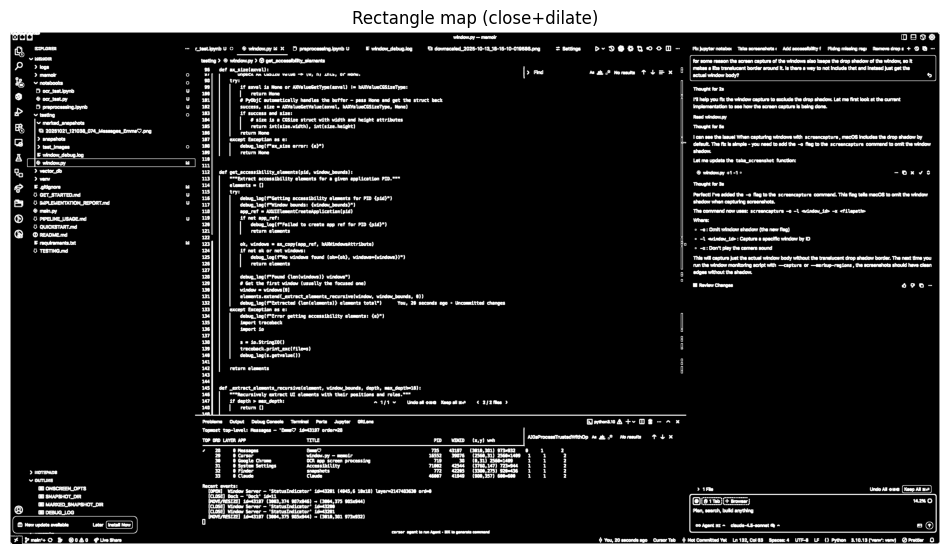

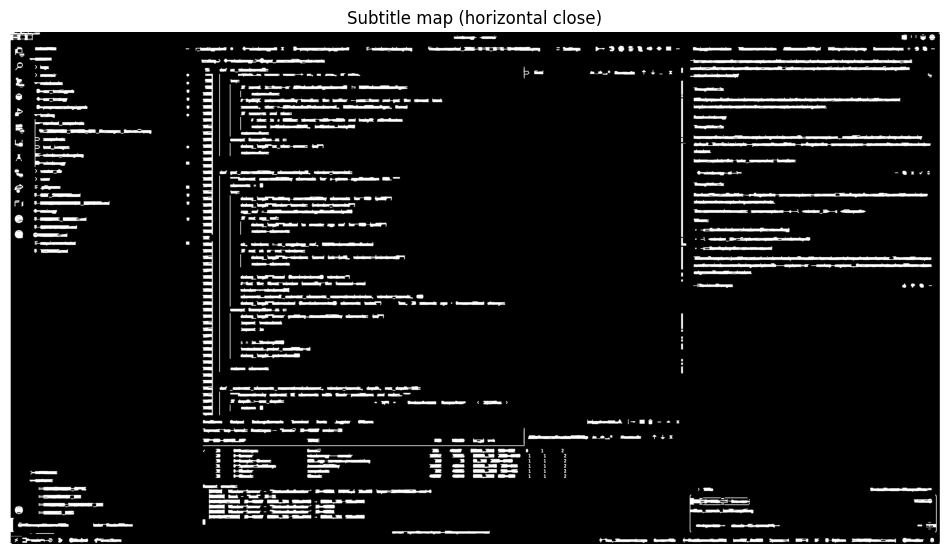

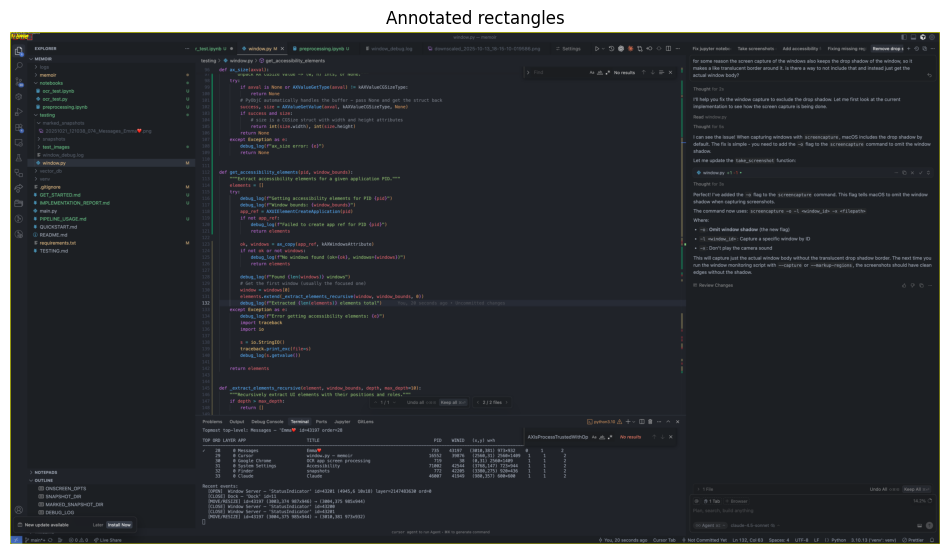

x  y     w     h  area_pct    extent  aspect_ratio  label
0  0  0  5120  2818     100.0  0.998729      1.816891  frame

### 20251021_122151_200_Google_Chrome_Parks_&_Rec_but_all_the_Women_WANT_Ron_|_Parks_and.png

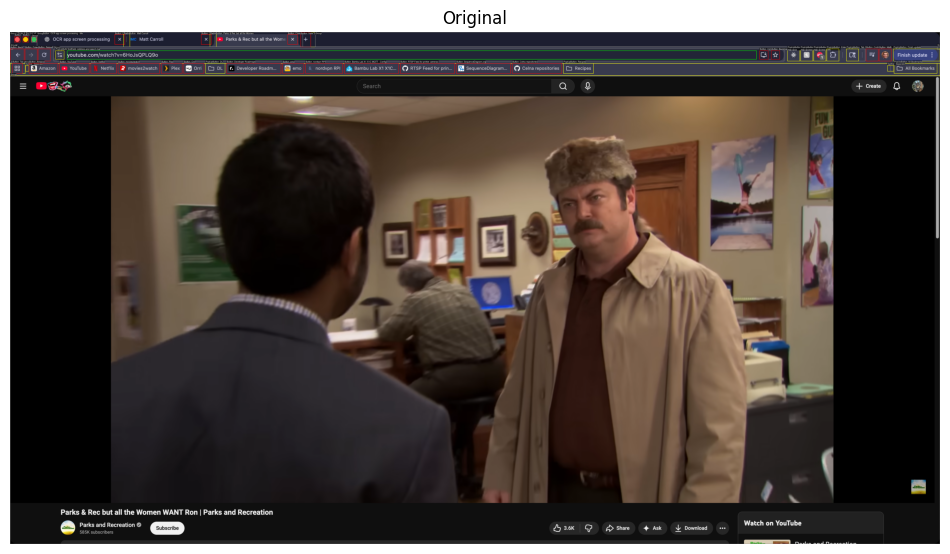

Auto Canny thresholds: low=12.22, high=27.17


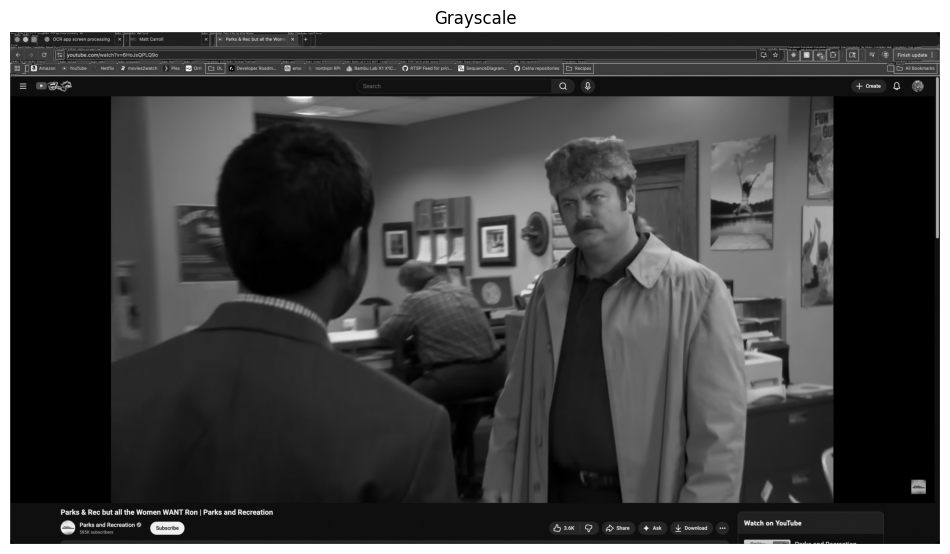

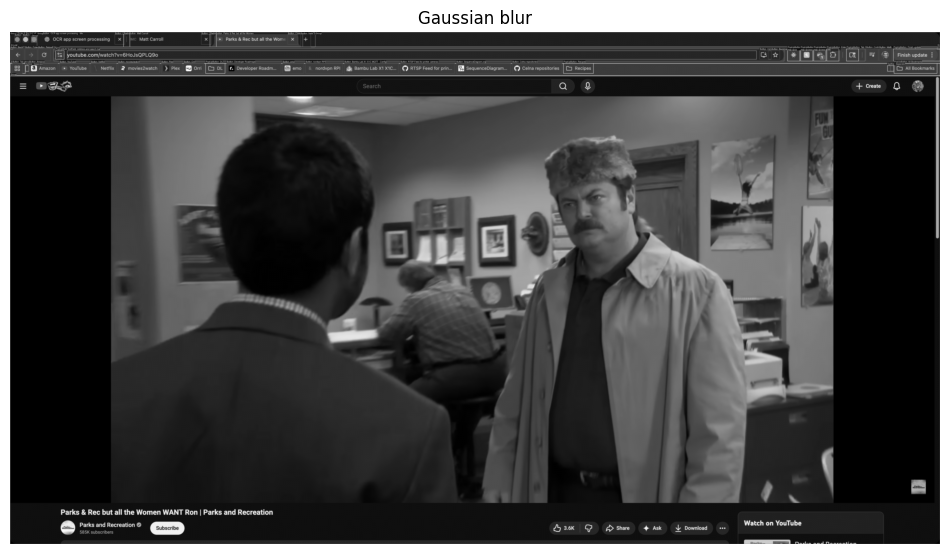

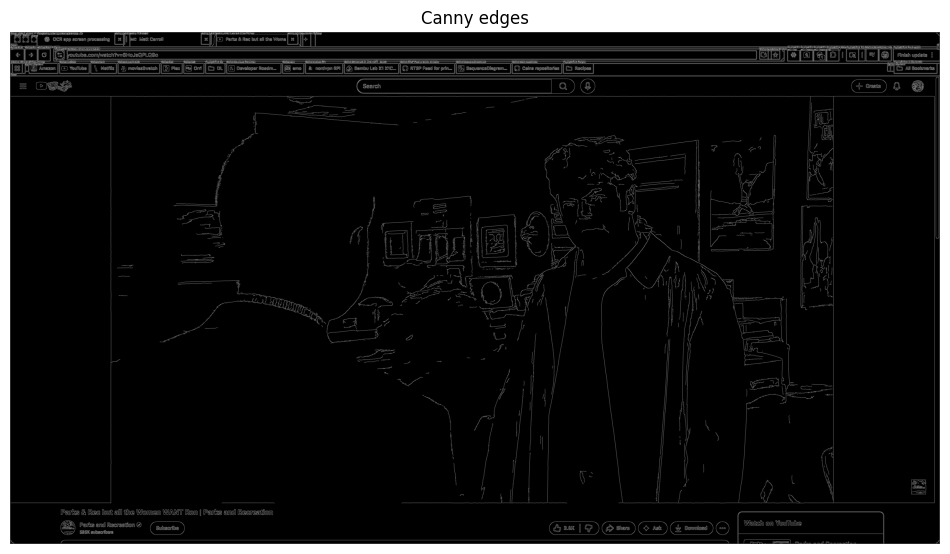

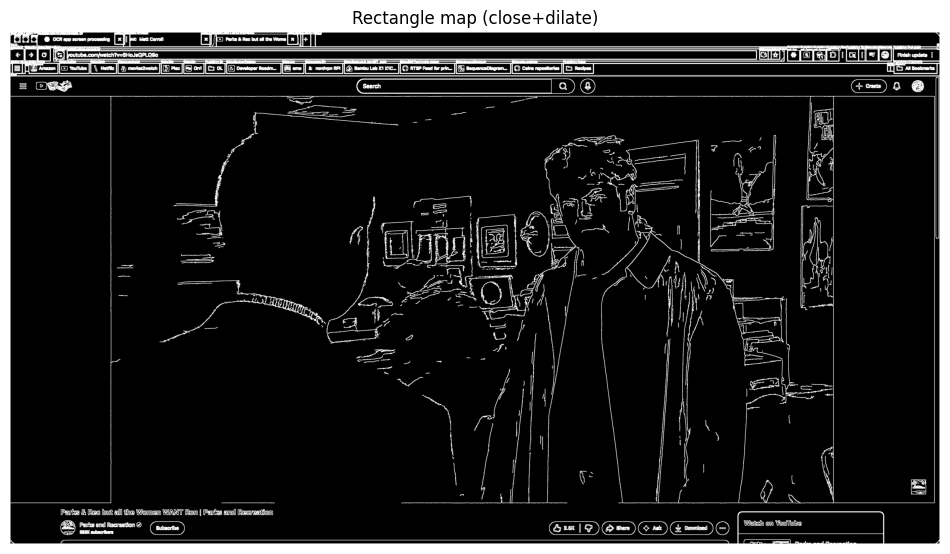

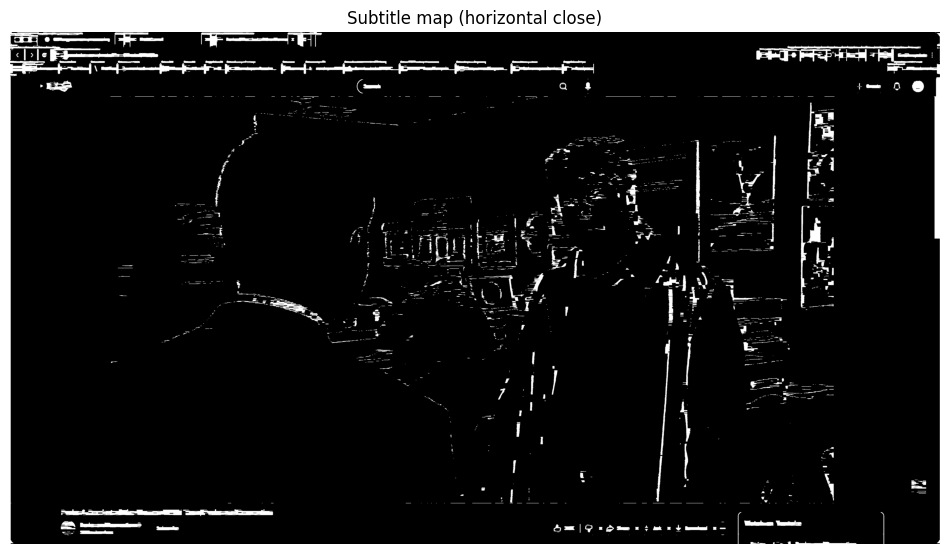

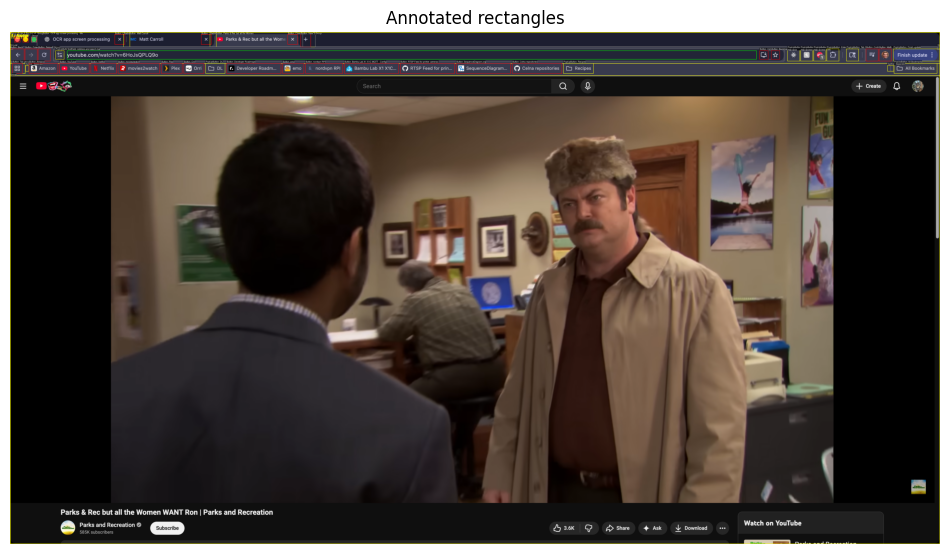

x  y     w     h  area_pct    extent  aspect_ratio  label
0  0  0  5120  2818     100.0  0.996475      1.816891  frame

### 20251021_122152_434_Google_Chrome_Parks_&_Rec_but_all_the_Women_WANT_Ron_|_Parks_and.png

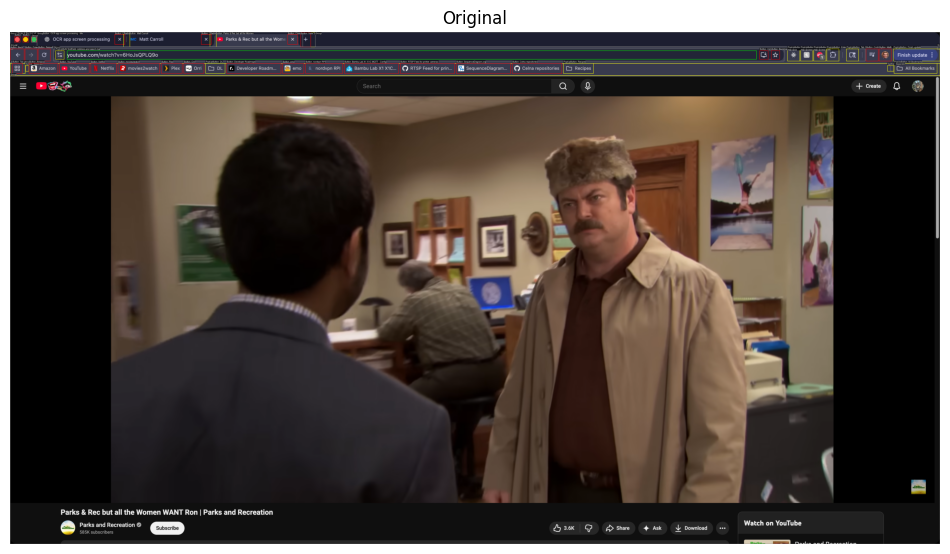

Auto Canny thresholds: low=12.22, high=27.17


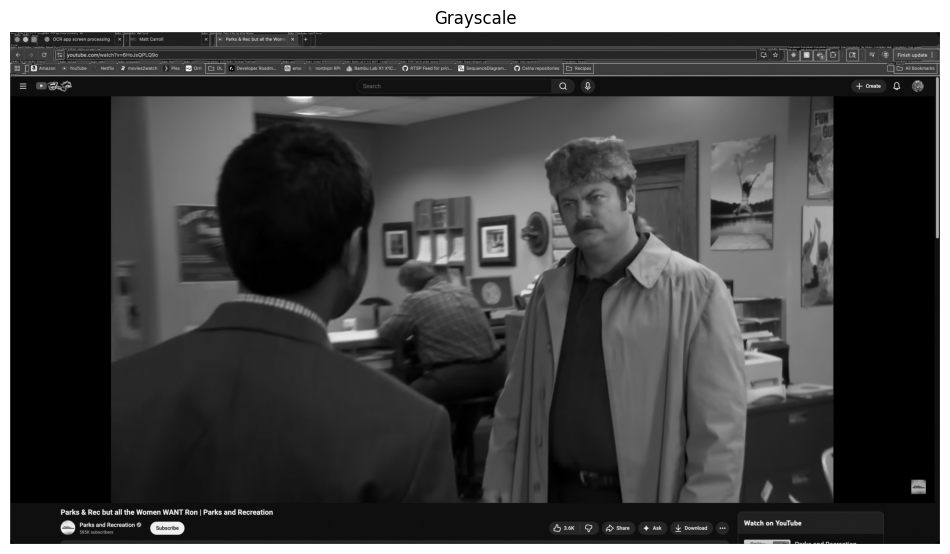

In [ ]:
def analyze_image(image_path, sigma=1.0, hi_q=0.92, low_ratio=0.45):
    display(Markdown(f"### {image_path.name}"))
    image_bgr = cv2.imread(str(image_path))
    if image_bgr is None:
        raise ValueError(f"Failed to load image at {image_path}.")

    image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
    height, width = image_rgb.shape[:2]
    plot_image("Original", image_rgb)

    gray = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2GRAY)
    edges, (lo, hi), blurred = canny_auto(gray, sigma=sigma, hi_q=hi_q, low_ratio=low_ratio)
    print(f"Auto Canny thresholds: low={lo:.2f}, high={hi:.2f}")

    plot_image("Grayscale", gray, cmap="gray")
    plot_image("Gaussian blur", blurred, cmap="gray")
    plot_image("Canny edges", edges, cmap="gray")

    frame_kernel = np.ones((3, 3), np.uint8)
    frame_mask = cv2.morphologyEx(edges, cv2.MORPH_CLOSE, frame_kernel, iterations=1)
    frame_mask = cv2.dilate(frame_mask, frame_kernel, iterations=1)
    plot_image("Frame emphasis (close+dilate)", frame_mask, cmap="gray")

    vertical_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 25))
    vertical_mask = cv2.morphologyEx(edges, cv2.MORPH_CLOSE, vertical_kernel, iterations=2)
    vertical_mask = cv2.morphologyEx(vertical_mask, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_RECT, (1, 3)), iterations=1)
    plot_image("Vertical emphasis", vertical_mask, cmap="gray")

    horizontal_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (25, 1))
    horizontal_mask = cv2.morphologyEx(edges, cv2.MORPH_CLOSE, horizontal_kernel, iterations=2)
    horizontal_mask = cv2.morphologyEx(horizontal_mask, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_RECT, (3, 1)), iterations=1)
    plot_image("Horizontal emphasis", horizontal_mask, cmap="gray")

    contours_frame, _ = cv2.findContours(frame_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours_vertical, _ = cv2.findContours(vertical_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours_horizontal, _ = cv2.findContours(horizontal_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    frame_roi = None
    if contours_frame:
        largest = max(contours_frame, key=cv2.contourArea)
        peri = cv2.arcLength(largest, True)
        approx = cv2.approxPolyDP(largest, 0.02 * peri, True)
        x, y, w, h = cv2.boundingRect(largest)
        rect_area = w * h
        fill = cv2.contourArea(largest) / (rect_area + 1e-6)
        aspect_ratio = w / float(h + 1e-6)
        if fill > 0.7 and 1.4 < aspect_ratio < 2.0 and len(approx) >= 4:
            frame_roi = (x, y, w, h)

    image_area = height * width
    min_area = 0.005 * image_area
    boxes = []
    seen_rects = set()

    def mask_coverage(mask, x, y, w, h):
        roi = mask[y:y + h, x:x + w]
        if roi.size == 0:
            return 0.0
        return float(roi.sum()) / (255.0 * w * h + 1e-6)

    def categorize_box(x, y, w, h, img_w, img_h, frame, vertical_cov, horizontal_cov):
        categories = []
        frame_flag = False

        edge_margin = 0.05
        frame_margin = 0.03
        width_ratio = w / float(img_w + 1e-6)
        height_ratio = h / float(img_h + 1e-6)

        top_edge = y <= edge_margin * img_h
        bottom_edge = (y + h) >= (1.0 - edge_margin) * img_h
        left_edge = x <= edge_margin * img_w
        right_edge = (x + w) >= (1.0 - edge_margin) * img_w

        if frame is not None:
            fx, fy, fw, fh = frame
            overlap_w = min(x + w, fx + fw) - max(x, fx)
            overlap_h = min(y + h, fy + fh) - max(y, fy)
            if overlap_w > 0 and overlap_h > 0:
                overlap_area = overlap_w * overlap_h
                frame_area = fw * fh
                box_area = w * h
                if overlap_area / float(box_area + 1e-6) > 0.85 and overlap_area / float(frame_area + 1e-6) > 0.6:
                    frame_flag = True
            top_edge = top_edge or y <= fy + frame_margin * fh
            bottom_edge = bottom_edge or (y + h) >= fy + fh - frame_margin * fh
            left_edge = left_edge or x <= fx + frame_margin * fw
            right_edge = right_edge or (x + w) >= fx + fw - frame_margin * fw

        vertical_threshold = 0.015
        horizontal_threshold = 0.015

        if top_edge and width_ratio > 0.25 and horizontal_cov > horizontal_threshold:
            categories.append("top_bar")
        if bottom_edge and width_ratio > 0.25 and horizontal_cov > horizontal_threshold:
            categories.append("bottom_bar")
        if left_edge and height_ratio > 0.25 and vertical_cov > vertical_threshold:
            categories.append("left_sidebar")
        if right_edge and height_ratio > 0.25 and vertical_cov > vertical_threshold:
            categories.append("right_sidebar")

        if frame_flag and "frame" not in categories:
            categories.insert(0, "frame")
        return categories

    contour_groups = [
        ("frame_mask", contours_frame),
        ("vertical_mask", contours_vertical),
        ("horizontal_mask", contours_horizontal),
    ]

    for source_name, contour_list in contour_groups:
        for contour in contour_list:
            x, y, w, h = cv2.boundingRect(contour)
            area = w * h
            if area < min_area:
                continue
            extent = cv2.contourArea(contour) / float(area + 1e-6)
            if extent < 0.2:
                continue

            vertical_cov = mask_coverage(vertical_mask, x, y, w, h)
            horizontal_cov = mask_coverage(horizontal_mask, x, y, w, h)

            categories = categorize_box(x, y, w, h, width, height, frame_roi, vertical_cov, horizontal_cov)
            if not categories:
                continue

            key = (categories[0], int(x / 4), int(y / 4), int(w / 4), int(h / 4))
            if key in seen_rects:
                continue
            seen_rects.add(key)

            boxes.append({
                "source": source_name,
                "primary_label": categories[0],
                "x": x,
                "y": y,
                "w": w,
                "h": h,
                "area_pct": 100 * area / image_area,
                "extent": extent,
                "aspect_ratio": w / float(h + 1e-6),
                "vertical_cov": vertical_cov,
                "horizontal_cov": horizontal_cov,
                "label": "/".join(categories),
            })

    if frame_roi is not None and all(box["primary_label"] != "frame" for box in boxes):
        fx, fy, fw, fh = frame_roi
        boxes.append({
            "source": "frame_mask",
            "primary_label": "frame",
            "x": fx,
            "y": fy,
            "w": fw,
            "h": fh,
            "area_pct": 100 * (fw * fh) / image_area,
            "extent": 1.0,
            "aspect_ratio": fw / float(fh + 1e-6),
            "vertical_cov": mask_coverage(vertical_mask, fx, fy, fw, fh),
            "horizontal_cov": mask_coverage(horizontal_mask, fx, fy, fw, fh),
            "label": "frame",
        })

    if not boxes:
        print("No rectangular sections detected above the area threshold.")
        return pd.DataFrame()

    color_map = {
        "frame": (0, 255, 255),
        "top_bar": (0, 165, 255),
        "bottom_bar": (0, 255, 255),
        "left_sidebar": (255, 0, 0),
        "right_sidebar": (255, 0, 255),
    }

    candidate_overlay = image_bgr.copy()
    for box in boxes:
        primary_label = box["primary_label"]
        color = color_map.get(primary_label, (0, 128, 255))
        x, y, w, h = box["x"], box["y"], box["w"], box["h"]
        cv2.rectangle(candidate_overlay, (x, y), (x + w, y + h), color, thickness=2)
    candidate_rgb = cv2.cvtColor(candidate_overlay, cv2.COLOR_BGR2RGB)
    plot_image("Candidate outlines", candidate_rgb)

    annotated_bgr = image_bgr.copy()
    if frame_roi is not None:
        fx, fy, fw, fh = frame_roi
        cv2.rectangle(annotated_bgr, (fx, fy), (fx + fw, fy + fh), (0, 255, 255), thickness=4)
        cv2.putText(
            annotated_bgr,
            "frame",
            (fx + 5, fy + 35),
            cv2.FONT_HERSHEY_SIMPLEX,
            1.0,
            (0, 255, 255),
            2,
            lineType=cv2.LINE_AA,
        )

    for rank, box in enumerate(sorted(boxes, key=lambda item: item["area_pct"], reverse=True), start=1):
        primary_label = box["primary_label"]
        if primary_label == "frame":
            continue
        color = color_map.get(primary_label, (0, 128, 255))
        x, y, w, h = box["x"], box["y"], box["w"], box["h"]
        cv2.rectangle(annotated_bgr, (x, y), (x + w, y + h), color, thickness=3)
        cv2.putText(
            annotated_bgr,
            f"{rank}: {box['label']} ({box['source']})",
            (x + 5, y + 25),
            cv2.FONT_HERSHEY_SIMPLEX,
            0.7,
            color,
            2,
            lineType=cv2.LINE_AA,
        )

    annotated_rgb = cv2.cvtColor(annotated_bgr, cv2.COLOR_BGR2RGB)
    plot_image("Annotated rectangles", annotated_rgb)

    df = pd.DataFrame(boxes)
    df = df.sort_values("area_pct", ascending=False)
    df["area_pct"] = df["area_pct"].round(2)
    df["extent"] = df["extent"].round(3)
    df["vertical_cov_pct"] = (df["vertical_cov"] * 100).round(2)
    df["horizontal_cov_pct"] = (df["horizontal_cov"] * 100).round(2)
    df = df.drop(columns=["vertical_cov", "horizontal_cov"])
    df = df[
        [
            "primary_label",
            "label",
            "source",
            "x",
            "y",
            "w",
            "h",
            "area_pct",
            "extent",
            "aspect_ratio",
            "vertical_cov_pct",
            "horizontal_cov_pct",
        ]
    ]
    display(df)
    return df


In [ ]:
all_boxes = []
for path in image_paths:
    df = analyze_image(path)
    if not df.empty:
        df.insert(0, "image", path.name)
        all_boxes.append(df)

if all_boxes:
    summary_df = pd.concat(all_boxes, ignore_index=True)
    summary_df = summary_df.sort_values(["image", "primary_label", "area_pct"], ascending=[True, True, False])
    display(Markdown("#### Combined box summary"))
    display(summary_df)
else:
    print("No box candidates detected across the dataset.")
